## LSTM과 GRU 셀

### LSTM 구조

LSTM(Long-Term Memory)
- 단기 기억을 오래 기억하기 위해 고안됨

- 입력과 가중치를 곱하고 절편을 더해 활성화 함수를 통과 시키는 구조를 여러 개 가지고 있음
- 이러한 계산 결과는 다음 타임스텝에 재사용됨

1. 은닉 상태를 만드는 방법

- 은닉 상태는 입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수를 통과시켜 다음 은닉 상태를 만든다
- 이때 기본 순환층과는 달리 시그모이드 활성화 함수를 사용
- 또 tanh 활성화 함수를 통과한 어떤 값과 곱해져서 은닉 상태를 만든다

- LSTM에는 순환되는 상태가 2개이다

- 은닉 상태, 셀 상태(cell state)
- 은닉 상태와 달리 셀 상태는 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 되는 값

2. 셀 상태를 계산하는 과정
- 입력과 은닉 상태를 또 다른 가중치 w1에 곱한 다음 시그모이드 함수 통과
- 이전 타임스텝의 셀 상태와 곱하여 새로운 셀 상태 만들기

- 이 셀 상태가 오른쪽에서 tanh 함수를 통과하여 새로운 은닉 상태를 만드는 데 기여

- LSTM은 마치 작은 셀을 여러 개 표함하고 있는 큰 셀 같음

- 중요한 것은 입력과 은닉 상태에 곱해지는 가중치 w0과 w1이 다르다는 것
- 두 작은 셀은 각기 다른 기능을 위해 훈련됨

- 여기에 2개의 작은 셀이 더 추가되어 셀 상태를 만드는 데 기여!!

- - LSTM에는 총 4개의 셀이 있다

- 입력과 은닉 상태를 각기 다른 가중치에 곱한 다음, 하나는 시그모이드 함수를 통과시키고 다른 하나는 tanh 함수를 통과시킴

- 그다음 두 결과를 곱한 후 이전 셀 상태와 더한다
- - 이 결과가 최종적인 다음 셀 상태가 됨

- 삭제 게이트 : 셀 상태에 있는 정보를 제거하는 역할

- 입력 게이트 : 새로운 정보를 셀 상태에 추가
- 출력 게이트 : 이 셀 상태가 다음 은닉 상태로 출력

### LSTM 신경망 훈련하기

In [ ]:
# IMDB 리뷰 데이터를 로드하고 훈련 세트와 검증 세트로 나누기
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [ ]:
# 케라스의 pad_sequences() 함수로 각 샘플의 길이를 100에 맞추고 부족할 때는 패딩을 추가
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [3]:
# LSTM 순환층 만들기
# SimpleRNN 클래스를 LSTM 클래스로 바꾸기만 하면 된다
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

/Users/youju/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:103: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# 모델을 컴파일하고 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5281 - loss: 0.6927 - val_accuracy: 0.5488 - val_loss: 0.6919
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5747 - loss: 0.6909 - val_accuracy: 0.5824 - val_loss: 0.6898
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6003 - loss: 0.6880 - val_accuracy: 0.6088 - val_loss: 0.6860
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6237 - loss: 0.6823 - val_accuracy: 0.6298 - val_loss: 0.6781
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6521 - loss: 0.6691 - val_accuracy: 0.6652 - val_loss: 0.6571
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6971 - loss: 0.6151 - val_accuracy: 0.7208 - val_loss: 0.5819
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7385 - loss: 0.5583 - val_accuracy: 0.7394 - val_loss: 0.5477
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7527 - loss: 0.5310 - 

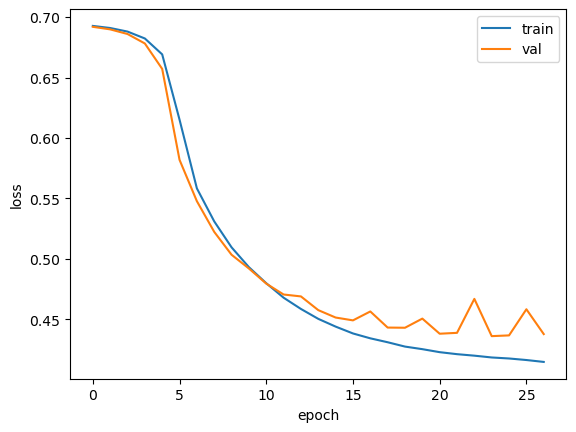

In [6]:
# 훈련 손실과 검증 손실 그래프 그리기
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 순환층에 드롭아웃 적용하기

- 순환층은 자체적으로 드롭아웃 기능을 제공
- - 드롭아웃 : 은닉층에 있는 뉴런의 출력을 랜덤하게 꺼서 과대적합을 막는 기법

- SimpleRNN과 LSTM 클래스 모두 dropout 매개변수와 recurrent_dropout 매개변수를 가지고 있음

- dropout 매개변수는 셀의 입력에 드롭아웃을 적용
- recurrent_dropout은 순환되는 은닉 상태에 드롭아웃을 적용

- 하지만 기술적인 문제로 인해 recurrent_dropout을 사용해면 GPU를 사용하여 모델을 훈련하지 못함
- 이 때문에 모델의 훈련 속도가 크게 느려짐

In [7]:
# LSTM 클래스에 dropout 매개변수를 0.3으로 지정하여 30%의 입력을 드롭아웃
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

/Users/youju/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:103: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# 모델 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5215 - loss: 0.6927 - val_accuracy: 0.5358 - val_loss: 0.6924
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5589 - loss: 0.6915 - val_accuracy: 0.5772 - val_loss: 0.6909
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5947 - loss: 0.6894 - val_accuracy: 0.6116 - val_loss: 0.6877
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6295 - loss: 0.6835 - val_accuracy: 0.6558 - val_loss: 0.6778
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6678 - loss: 0.6599 - val_accuracy: 0.7068 - val_loss: 0.6258
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7067 - loss: 0.5950 - val_accuracy: 0.7112 - val_loss: 0.5752
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7264 - loss: 0.5621 - val_accuracy: 0.7420 - val_loss: 0.5487
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7472 - loss: 0.5371 - 

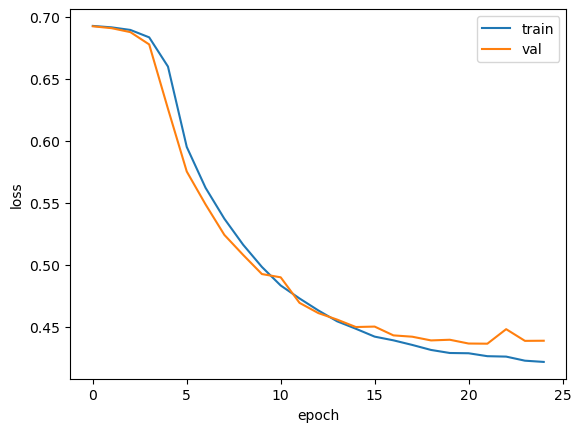

In [9]:
# 훈련 손실 검증 손실 그래프 그리기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 2개의 층을 연결하기

- 순환층의 은닉 상태는 샘플의 마지막 타임스텝에 대한 은닉 상태만 다음 층으로 전달

- 하지만 순환층을 쌓게 되면 모든 순환 층에 순차 데이터가 필요
- 따라서 앞쪽의 순환층이 모든 타임스텝에 대한 은닉 상태를 출력해야 함
- 오직 마지막 타임스텝의 은닉 상태를 출력해야 한다

- 케라스의 순환층에서 모든 타임스텝의 은닉 상태를 출력하려면 마지막을 제외한 다른 모든 순환층에서 return_sequences 매개변수를 True로 지정하면 됨

In [10]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

In [11]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 8)         │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# 모델 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.5341 - loss: 0.6925 - val_accuracy: 0.5474 - val_loss: 0.6919
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5712 - loss: 0.6905 - val_accuracy: 0.6294 - val_loss: 0.6881
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.6276 - loss: 0.6814 - val_accuracy: 0.6660 - val_loss: 0.6688
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6747 - loss: 0.6366 - val_accuracy: 0.7096 - val_loss: 0.5873
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7188 - loss: 0.5714 - val_accuracy: 0.7348 - val_loss: 0.5406
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7425 - loss: 0.5343 - val_accuracy: 0.7552 - val_loss: 0.5166
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7629 - loss: 0.5103 - val_accuracy: 0.7650 - val_loss: 0.4990
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7671 - loss: 0

- 일반적으로 순환층을 쌓으면 성능이 높이진다

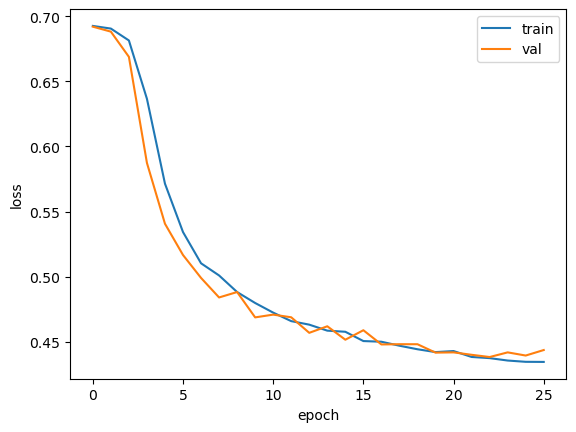

In [13]:
# 손실 그래프를 그려서 과대적합이 잘 제어되었는지 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### GRU 구조

GRU(Gated Recurrent Unit)
- LSTM을 간소화한 버전

- LSTM처럼 셀 상태를 계산하지 않고 은닉 상태 하나만 포함하고 있음

- GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀이 3개 들어 있음

- 2개는 시그모이드 활성화 함수를 사용
- 하나는 tanh 활성화 함수를 사용
- 여기에서도 은닉 상태와 입력에 곱해지는 가중치를 합쳐서 나타냄

- 맨 왼쪽 가중치를 사용하는 셀의 출력이 은닉 상태에 바로 곱해져 삭제 게이트 역할을 수행

- 이와 똑같은 출력을 1에서 뺀 다음에 가장 오른쪽 가중치를 사용하는 셀의 출력에 곱하여 입력돠는 정보를 제어하는 역할을 수행
- 가운데 가중치를 사용하는 셀에서 출력된 값은 가장 오른쪽 가중치 셀이 사용할 은닉 상태의 정보를 제어

### GRU 신경망 훈련하기


In [14]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

In [15]:
model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 8)              │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,633 (33.72 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# GPU 셀을 사용한 순환 신경망 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5117 - loss: 0.6930 - val_accuracy: 0.5418 - val_loss: 0.6924
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5486 - loss: 0.6919 - val_accuracy: 0.5630 - val_loss: 0.6913
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5709 - loss: 0.6903 - val_accuracy: 0.5754 - val_loss: 0.6894
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5832 - loss: 0.6877 - val_accuracy: 0.5926 - val_loss: 0.6861
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6051 - loss: 0.6833 - val_accuracy: 0.6012 - val_loss: 0.6809
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6174 - loss: 0.6759 - val_accuracy: 0.6158 - val_loss: 0.6722
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6335 - loss: 0.6637 - val_accuracy: 0.6326 - val_loss: 0.6576
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6551 - loss: 0.6432 - 

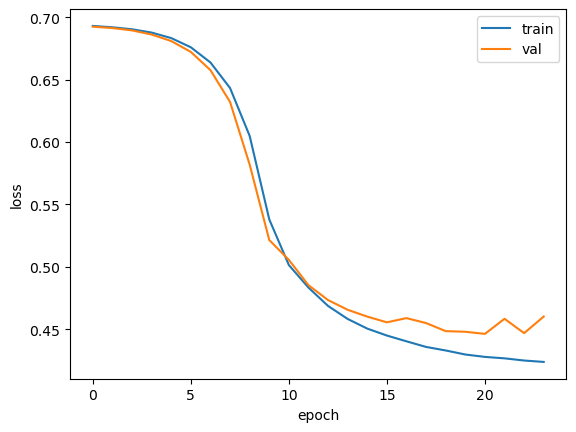

In [17]:
# 모델의 손실을 그래프로 그리기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()